In [ ]:
# ===================================================================
# PROJECT SETUP BLOCK
# Run this entire cell every time you start a new session in Colab.
# ===================================================================

# 1. Install necessary libraries
!pip install kaggle

# 2. Authenticate with Kaggle
# This part requires you to upload your 'kaggle.json' file again.
from google.colab import files
import os

print("Please upload your kaggle.json file:")
# Check if the file is already uploaded to avoid re-uploading if the session is still active
if not os.path.exists("kaggle.json"):
    uploaded = files.upload()
    if "kaggle.json" not in uploaded:
        print("\nERROR: kaggle.json was not uploaded. Please run the cell again.")
    else:
        print("\nkaggle.json uploaded successfully.")
else:
    print("kaggle.json already exists.")

# Configure the Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nKaggle API configured.")

# 3. Download and Unzip the Dataset
zip_file_name = 'hardfakevsrealfaces.zip'
zip_path = os.path.join('/content', zip_file_name)
extract_path = '/content/dataset_final'

# Check if data is already unzipped to save time
if not os.path.exists(extract_path):
    print(f"\nDataset not found. Downloading '{zip_file_name}'...")
    !kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces -p /content/

    print(f"\nUnzipping '{zip_file_name}'...")
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Unzipping complete.")
else:
    print("\nDataset already downloaded and unzipped.")

# 4. Final Verification
# Verify that the correct data directory exists.
data_dir_check = os.path.join(extract_path)
if os.path.exists(data_dir_check) and 'real' in os.listdir(data_dir_check):
    print(f"\n✅ SETUP COMPLETE. The data is ready in: {data_dir_check}")
    print("You can now proceed with the rest of the notebook.")
else:
    print("\n❌ SETUP FAILED. Something went wrong. Please review the output above.")



Please upload your kaggle.json file:
kaggle.json already exists.

Kaggle API configured.

Dataset not found. Downloading 'hardfakevsrealfaces.zip'...
Dataset URL: https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces
License(s): CC0-1.0
  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.08GB/s]

Unzipping 'hardfakevsrealfaces.zip'...
Unzipping complete.

✅ SETUP COMPLETE. The data is ready in: /content/dataset_final
You can now proceed with the rest of the notebook.


Step 3: Prepare dataset for tensorflow

In [10]:
# Step 3: Prepare the Data for TensorFlow

import tensorflow as tf

# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# The directory that contains the 'real' and 'fake' subfolders
DATA_DIR = '/content/dataset_final'

# Create a training dataset from the directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='binary'
)

# Create a validation dataset from the same directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='binary'
)

# Get the class names
class_names = train_dataset.class_names
print("Class names found by TensorFlow:", class_names)

# Improve performance by prefetching data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

print("\nData is now successfully prepared for training!")

Found 1289 files belonging to 2 classes.
Using 1032 files for training.
Found 1289 files belonging to 2 classes.
Using 257 files for validation.
Class names found by TensorFlow: ['fake', 'real']

Data is now successfully prepared for training!


Step 4: Build the Model

In [11]:
# Step 4: Build the CNN Model

from tensorflow.keras import layers
import tensorflow as tf

# Define the model using the Keras Sequential API
model = tf.keras.Sequential([
    # Input layer: Rescale pixel values from the [0, 255] range to the [0, 1] range.
    # This is a crucial preprocessing step.
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # First convolutional block
    # 32 filters, each 3x3 in size. 'relu' is the activation function.
    layers.Conv2D(32, (3, 3), activation='relu'),
    # MaxPooling reduces the size of the image, keeping the most important information.
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the results from the convolutional blocks into a single long vector.
    # This prepares the data for the final classification layers.
    layers.Flatten(),

    # A dense (or fully-connected) layer with 128 neurons for high-level pattern learning.
    layers.Dense(128, activation='relu'),

    # Dropout is a regularization technique to prevent overfitting.
    # It randomly "turns off" 50% of the neurons during training to make the model more robust.
    layers.Dropout(0.5),

    # The final output layer. It has a single neuron because this is a binary
    # (2-class) problem. The 'sigmoid' activation function will output a value
    # between 0 (for 'fake') and 1 (for 'real').
    layers.Dense(1, activation='sigmoid')
])

# Now, compile the model. This configures it for training.
model.compile(
    optimizer='adam',  # Adam is a popular and effective optimization algorithm.
    loss='binary_crossentropy', # This is the correct loss function for binary (0 or 1) classification.
    metrics=['accuracy'] # We want to monitor the accuracy during training.
)

# Finally, print a summary of the model's architecture.
# This shows you all the layers, their output shapes, and the number of parameters.
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 5: Train the Model

# We define the number of epochs. An epoch is one full pass through the entire training dataset.
EPOCHS = 15 # We'll start with 15 epochs. This might take a few minutes.

# We call the model's 'fit' method, which starts the training process.
# We provide it with our training data and our validation data.
# The 'history' object will store the training and validation loss and accuracy for each epoch.
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS
)

print("\nTraining complete!")


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.6623 - loss: 0.5663 - val_accuracy: 0.9922 - val_loss: 0.0357
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9903 - loss: 0.0335 - val_accuracy: 0.9883 - val_loss: 0.0280
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9923 - loss: 0.0291 - val_accuracy: 0.9416 - val_loss: 0.1403
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9923 - loss: 0.0202 - val_accuracy: 0.9922 - val_loss: 0.0167
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9883 - val_loss: 0.0509
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9929 - loss: 0.0254 - val_accuracy: 0.9961 - val_loss: 0.0153
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9961 - val_loss: 0.0134
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 1.0000 - loss: 5.4184e-04 - val_accuracy: 0.99

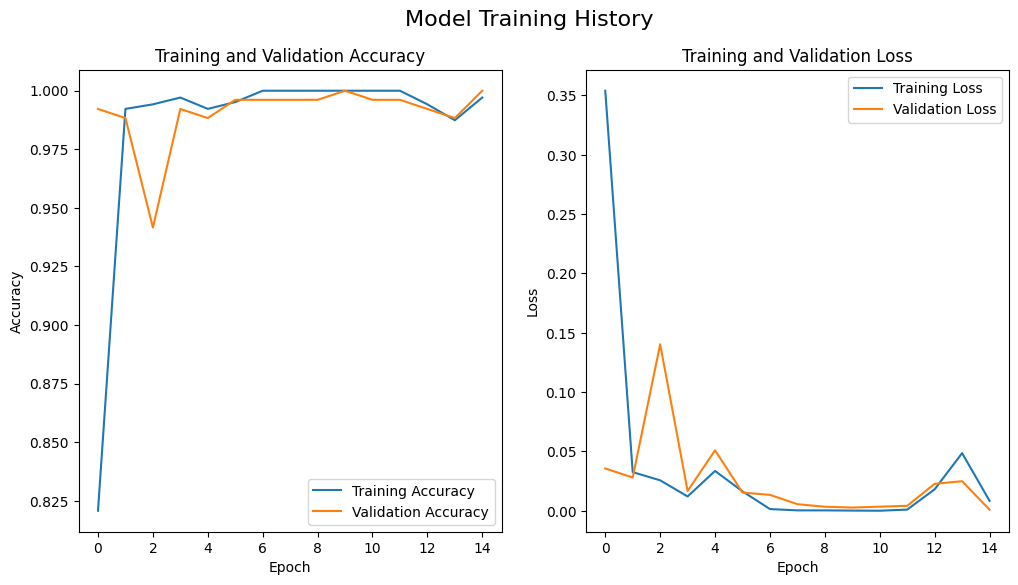

In [13]:
# Step 6: Evaluate and Visualize the Training Process

import matplotlib.pyplot as plt

# Retrieve the accuracy and loss from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.suptitle('Model Training History', fontsize=16)
plt.show()


In [14]:
# Step 7: Save the Trained Model

# Define the filename for your model. The '.h5' extension is a standard format
# for saving Keras models, which stores the architecture, weights, and optimizer state.
model_filename = 'deepfake_detector_v1.h5'

# Use the model.save() function to save the entire model to a single file.
model.save(model_filename)

print(f"\nModel successfully saved as '{model_filename}'")
print("You can now find this file in the file browser on the left and download it.")


Model successfully saved as 'deepfake_detector_v1.h5'
You can now find this file in the file browser on the left and download it.
